<a href="https://colab.research.google.com/github/tatsath/PortfolioOptimization/blob/main/DigitalOptionPrice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [11]:
import numpy as np

import seaborn as sns
import numpy.matlib


import matplotlib.pyplot as plt
from matplotlib import cm

from scipy import stats
from scipy.stats import norm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import time

import copy



In [12]:
#Setting seed
torch.manual_seed(20)
torch.cuda.manual_seed(20)
np.random.seed(20)

In [13]:
# 1 asset 
params = {
    "S0" : np.array([100]),
    "mu" : np.array([0.03]),
    "sigma" : np.array([0.8]),
    "rho" : np.array([[1]]),
    "rf" : 0.01,
    "delta" : np.array([0.7])
    }
params_Q = copy.copy(params)

In [14]:
#%% Simulation Engine for price paths
def SimPath(Ndt, params, T, Nsims):
    
    dt = T/Ndt
    
    N_assets= 1
    
    assert N_assets == params["sigma"].shape[0], "#assets in mu != #assets in sigma"
    assert N_assets == params["rho"].shape[0], "#assets in mu != #assets in rho"
    assert params["rho"].ndim == 2, "rho must be matrix"
    assert N_assets == params["rho"].shape[1], "rho not square matrix"
    
    S = np.zeros((Ndt+1, Nsims, N_assets ))
    S[0,:,:] = params["S0"]

    
    for i in range(Ndt):
        
        dW = np.sqrt(dt) * np.random.multivariate_normal(np.zeros(N_assets), params["rho"], Nsims)
        S[i+1,:,:] = S[i,:,:] * np.exp((params["mu"]-0.5*params["sigma"]**2)*dt + params["sigma"]*dW)
        
    t = np.linspace(0,T,Ndt+1)
    return t, S
        

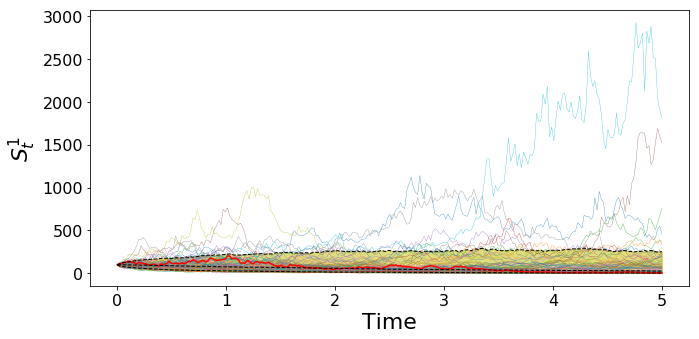

In [15]:
# Sim some paths and show sims with quantiles and a sample path
t, S = SimPath(Ndt=252, params = params, T=5, Nsims = 1000)

plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 16})
plt.rc('axes', labelsize=22)
for i in range(S.shape[2]):
    
    plt.subplot(1,S.shape[2],i+1)
    
    plt.fill_between(t, np.quantile(S[:,:,i],0.1,axis=1).T, np.quantile(S[:,:,i],0.9,axis=1).T, color='y', alpha=0.5)
    plt.plot(t, S[:,:100,i],linewidth=0.3)
    plt.plot(t, S[:,0,i],color='r',linewidth=1.5)
    plt.plot(t, np.quantile(S[:,:,i],[0.1, 0.5, 0.9],axis=1).T,color='k',linewidth=1, linestyle='--')
    
    plt.xlabel("Time")
    plt.ylabel("$S_t^" +str(i+1)+"$")
    
plt.tight_layout()
plt.show()

In [16]:
S.shape

(253, 1000, 1)

In [130]:
# the ANN for policy iteration
class MyNet(nn.Module):
    
    def __init__(self, n, n_assets ):
        super(MyNet, self).__init__()

        # 2 input layer (t, X_t^delta), 1 output channel, 3 hidden layers with n units each
        self.f_in_to_h1 = nn.Linear( 2 , n)
        self.f_h1_to_h2 = nn.Linear(n, n)
        self.f_h2_to_out = nn.Linear(n, n_assets)
        self.myReLU = nn.ReLU()

    def forward(self, x):
        
        # input into 1st hidden layer
        h1 = self.myReLU(self.f_in_to_h1(x) )
        
        # 1st hidden to 2nd hidden layer
        h2 = self.myReLU(self.f_h1_to_h2(h1))
            
        # 2nd hidden layer to output layer
        y = self.f_h2_to_out(h2)      
        #y = y.clamp(-1,1)
        #y = F.logsigmoid(h2)
        
        return y

In [131]:
# from a minibatch compute the risk measure
def GetRiskMeasure(X, Type):
    #TVaR    
    if (Type == "TVaR"):
        
        alpha = 0.15
        Qtl= torch.quantile(X, alpha)
        RiskMeasure = -torch.mean(X[X<=Qtl])   
            
    #Variance
    elif (Type == "Variance"):  
        RiskMeasure = torch.var(X)   
        
    return RiskMeasure

In [132]:
Ndt = 500
T =5
Nsims = 5000
t, S = SimPath(Ndt, params, T=T, Nsims=Nsims) 

In [133]:
 
#set_trace()
# initial investment amount
X0 = 1

num_asset = S.shape[2]
dt = t[1]-t[0]

# don't think we need sensitivities w.r.t. this as they are fixed per simulation
S_t = torch.tensor(S, dtype=torch.float, requires_grad=False, device=device)

In [134]:
x.shape

(501, 5000, 2)

In [135]:
S_t = torch.tensor(S, dtype=torch.float, requires_grad=False, device=device)
    
x=np.zeros((Ndt+1, Nsims, 2))   
x[:,:,0] = np.matlib.repmat(t.reshape(-1,1)/t[-1], 1, Nsims)

x[:,:,1] = S_t.squeeze()

In [137]:
xt = torch.tensor(x, dtype=torch.float, device=device)

In [138]:
delta_t = net(xt) 

In [139]:
delta_t.shape

torch.Size([501, 5000, 1])

In [140]:
delta_t[-1,:,:].squeeze().shape

torch.Size([5000])

In [141]:
S_t[-1,:,:].shape

torch.Size([5000, 1])

In [142]:
S_t[:-1,:,:].squeeze().shape

torch.Size([500, 5000])

In [143]:
Strike = 90
Payoff_T = torch.zeros(Nsims, dtype=torch.float, requires_grad=True, device=device)

S_Maturity = S_t[-1,:,:].squeeze()
Hedge_Maturity = delta_t[-1,:,:].squeeze()

In [144]:
Hedge_Maturity = delta_t[-1,:,:].squeeze()

In [145]:
Xcp = S_Maturity.clone().cpu().detach().numpy()
Ycp = Hedge_Maturity.clone().cpu().detach().numpy()

In [146]:
Payoff_T.shape

torch.Size([5000])

In [147]:
S_Maturity.shape


torch.Size([5000])

In [148]:
len(S_Maturity)

5000

In [115]:
for i in range(len(S_Maturity)):
    if(S_Maturity[i] >= Strike):
        Payoff_T[i] = -(S_Maturity[i]-Strike)
    else:
        Payoff_T[i] = 0 

In [84]:
PnL_T = Payoff_T - torch.sum((delta_t * (S_t[1:,:,:]-S_t[:-1,:,:])).squeeze(), axis =0)

In [86]:
RiskMeasure = GetRiskMeasure(PnL_T, "TVaR")

In [87]:
PnL_T

tensor([  -4456.9087,  -11662.6904,  -14229.5332,  ..., -141124.7812,
         -54280.6055, -175897.5312], grad_fn=<SubBackward0>)

In [88]:
RiskMeasure

tensor(674133.6250, grad_fn=<NegBackward>)

In [95]:
# given an ANN run a simulation and compute the riskmeasure
from IPython.core.debugger import set_trace

def SimRM(net, Ndt, T, Nsims, params, device):
      
    t, S = SimPath(Ndt, params, T=T, Nsims=Nsims) 
    num_asset = 1
    dt = t[1]-t[0]

    # don't think we need sensitivities w.r.t. this as they are fixed per simulation
    
    S_t = torch.tensor(S, dtype=torch.float, requires_grad=False, device=device)
    
    x=np.zeros((Ndt+1, Nsims, 2))   
    x[:,:,0] = np.matlib.repmat(t[1:].reshape(-1,1)/t[-1], 1, Nsims)

    x[:,:,1] = S_t

    xt = torch.tensor(x, dtype=torch.float, device=device, requires_grad=True)
    
    #Get the hedges from the NN
    delta_t = net(xt) 

    Strike = 100
    Payoff_T = torch.zeros(Nsims, dtype=torch.float, requires_grad=False, device=device)

    S_Maturity = S_t[-1,:,:].squeeze()
    Hedge_Maturity = delta_t[-1,:,:].squeeze()      
    
    #Get digital payoff for each scenario-Assuming short
    for i in range(len(S_Maturity)):
        if(S_Maturity[i] >= Strike):
            Payoff_T[i] = S_Maturity[i]-Strike
        else:
            Payoff_T[i] = 0 
    #set_trace()    
    PnL_T = -Payoff_T + torch.sum((delta_t * (S_t[1:,:,:]-S_t[:-1,:,:])).squeeze(), axis =0)    
       
    RiskMeasure = GetRiskMeasure(PnL_T, "TVaR")   
   
    return Hedge_Maturity, S_Maturity, PnL_T, RiskMeasure, t

#Plot St vs Wt

In [96]:
# plot histogram of portfolio, sample path, and show dependence of X^\pi on X^\delta
def PlotHists_Hedge(S_Maturity, Hedge_Maturity,t):
    
    Xcp = S_Maturity.clone().cpu().detach().numpy()
    Ycp = Hedge_Maturity.clone().cpu().detach().numpy()
    
    plt.figure(figsize=(15,5))

    plt.subplot(1,1,1)
    #bins = np.linspace(0,4,50)    
    # xs = [min(Xcp), max(Xcp)]
    # plt.plot(xs,xs,'--k' )
    plt.scatter(Xcp,Ycp, marker='o',color='r', s=5)
    plt.xlim(0,200)
    plt.ylim(0,10)

    plt.rcParams.update({'font.size': 16})
    plt.rc('axes', labelsize=22)

    plt.tight_layout()
    
    plt.show()

In [97]:
# create an ANN and use GPU if available

if torch.cuda.is_available():
    device = torch.device('cuda') 
else:
    device = torch.device('cpu') 

net = MyNet(50, len(params["S0"])).to(device)

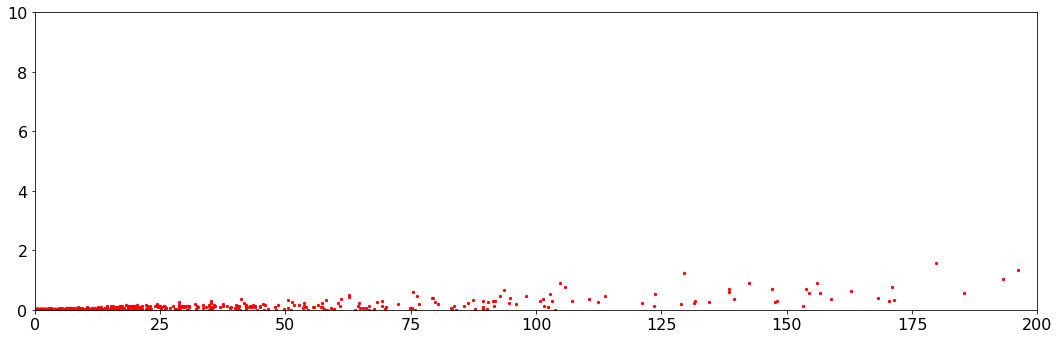

In [98]:
Hedge_Maturity, S_Maturity, PnL_T, RiskMeasure, t = SimRM(net, Ndt=252, T=5, Nsims=1000, params=params, device=device)
    
PlotHists_Hedge(S_Maturity, Hedge_Maturity,t)

In [99]:
torch.cuda.is_available()

False

...........10 duaration =  73.652  secs
Loss: -580.974


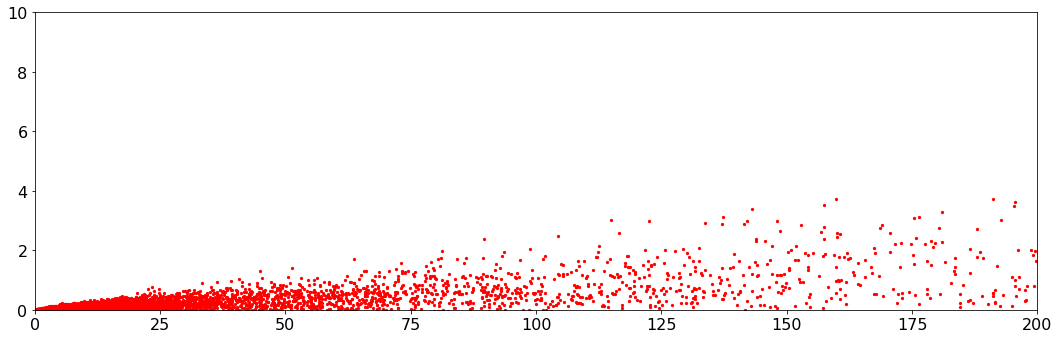

..........20 duaration =  67.281  secs
Loss: -1037.264


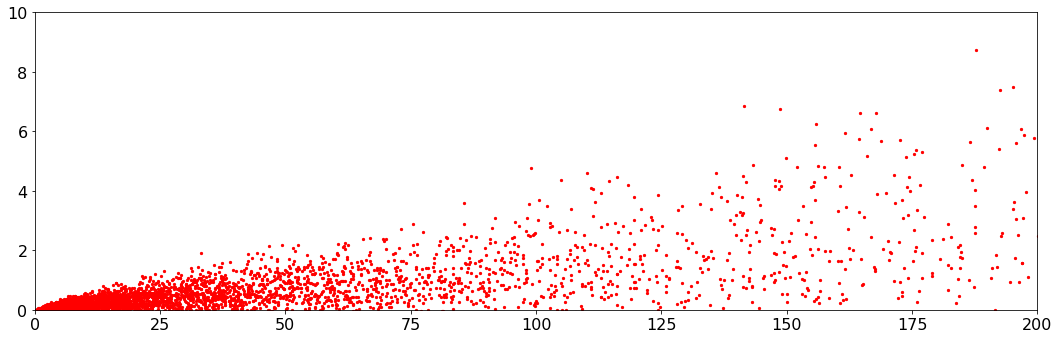

..........30 duaration =  66.779  secs
Loss: -1629.218


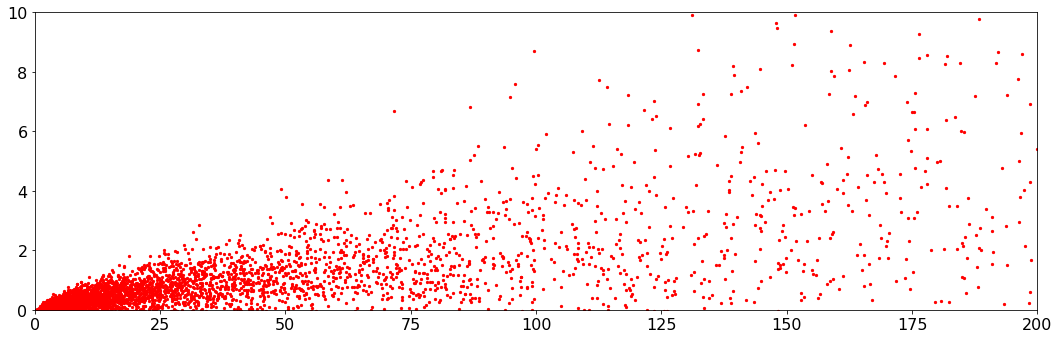

..........40 duaration =  75.539  secs
Loss: -2494.081


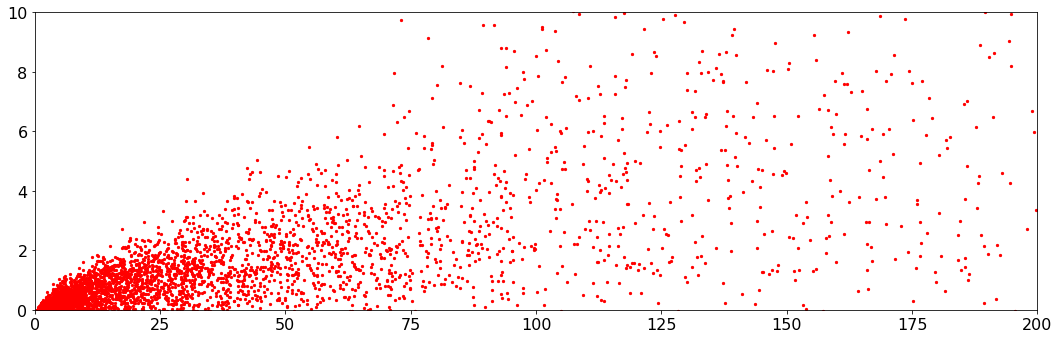

..........50 duaration =  70.215  secs
Loss: -3516.527


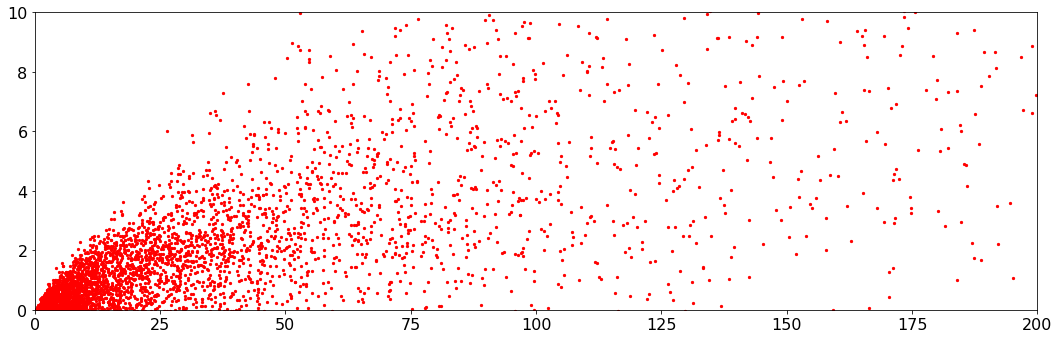

..........60 duaration =  72.460  secs
Loss: -4824.316


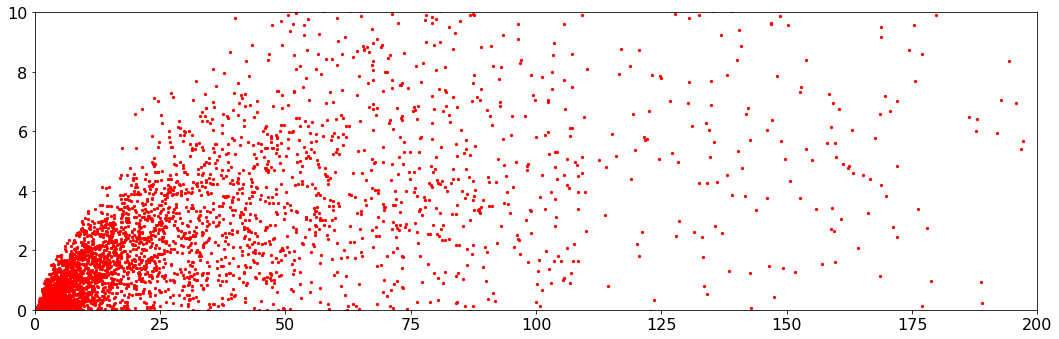

.

KeyboardInterrupt: 

In [100]:
# train the model

optimizer = optim.Adam(net.parameters())


Nepochs = 100
loss_hist = []
risk_history = []
wass_dist_history=[]

start_time= time.time()

for epoch in range(Nepochs):  # loop over the dataset multiple times

    
    
    # zero the parameter gradients
    optimizer.zero_grad()


    #hedge_payoff, true_payoff, S = SimHedge(net, Ndt, S0, mu, sigma, T, Nsims, True)
    Hedge_Maturity, S_Maturity, PnL_T, RiskMeasure, t = SimRM(net, Ndt=500, T=5, Nsims=10000, params=params, device=device)
    
    #loss = 100*(wass_dist)*(wass_dist>0.2) + RiskMeasure +100*(wass_dist)*(wass_dist>0.15)
    loss = RiskMeasure 
    
    loss.backward()   
    
    # optimize
    optimizer.step()
    
    # store running loss
    loss_hist.append(  loss.item() )
    risk_history.append( RiskMeasure.cpu().detach().numpy() )
    #wass_dist_history.append( wass_dist.cpu().detach().numpy() )
    
    print(".",end="")
    
    # plot output every 50 iterations
    if( (epoch % 10 == 0) and (epoch>1) ):
        
        print(epoch, end=" ")
        print("duaration = ", "{:.3f}".format(time.time() - start_time), " secs")
        start_time = time.time()
        
#         print("Wass Dist:", "{:.3f}".format(wass_dist_history[-1]), end=" " )
#         print("Risk Measure:", "{:.3f}".format(risk_history[-1]), end=" ")
        print("Loss:", "{:.3f}".format(loss.item()))

        PlotHists_Hedge(S_Maturity, Hedge_Maturity,t)
                
        
#         _, _, _, PortfolioVal_T_Q, BenchmarkVal_T_Q, _, _, _ = SimRM(net, Ndt=500, T=5, Nsims=10000, params=params_Q, device=device)
#         print(np.mean(np.exp(-params_Q["rf"]*5) * BenchmarkVal_T_Q.cpu().detach().numpy()), end=" ")
#         print(np.mean(np.exp(-params_Q["rf"]*5) * PortfolioVal_T_Q.cpu().detach().numpy()), end="\n\n")        
        

print('Finished Training')

In [ ]:
X_pi_T = np.zeros((0,1))
X_delta_T = np.zeros((0,1))
for i in range(10):
    _, _, _, PortfolioVal_T_Q, BenchmarkVal_T_Q, _, _, _ = SimRM(net, Ndt=500, T=5, Nsims=10000, params=params_Q, device=device)
    X_pi_T = np.concatenate((X_pi_T,PortfolioVal_T_Q.cpu().detach().numpy()))
    X_delta_T = np.concatenate((X_pi_T,BenchmarkVal_T_Q.cpu().detach().numpy()))
    
print(np.mean(np.exp(-params_Q["rf"]*5) * X_delta_T), end=" ")
print(np.mean(np.exp(-params_Q["rf"]*5) * X_pi_T), end="\n\n")  

In [ ]:
X_delta_T.shape

In [ ]:
def PlotStrat(net, device):
    
    t = np.linspace(0, 5, 100)
    X_delta_t = np.linspace(0.5, 3, 100)
     
    x1, x2 = np.meshgrid(t, X_delta_t)
    
    x = np.zeros((x1.shape[0], x1.shape[1], 2))
    
    x[:,:,0] = x1
    x[:,:,1] = x2
    
    x_t = torch.tensor(x, dtype=torch.float, device=device )
    
    w_t = net(x_t).cpu().detach().numpy()
        
    fig = plt.figure(figsize=(15,5))

    #params["delta"]
    
    for i in range(w_t.shape[2]):
            
        ax = fig.add_subplot(1, w_t.shape[2], i+1, projection='3d')
        #Normalizing the weights to get the ratio of portfolio and benchmark weight
        ax.plot_surface(x1, x2, w_t[:,:,i]/params["delta"][i], cmap=cm.coolwarm, linewidth=0, antialiased=False)
        
        ax.view_init(30, 30)
        
        plt.title('Asset' + str(i+1))
        
        plt.xlabel('t')
        plt.ylabel('x')
    
    plt.tight_layout()
    plt.show()
    
    
    # for i in range(0,x1.shape[1],5):
    
    #     fig = plt.figure(figsize=(10,5))
    
    #     plt.subplot(1,3,1)
    #     plt.plot(X_delta_t, w_t[:,i,0])
        
    #     plt.subplot(1,3,2)
    #     plt.plot(X_delta_t, w_t[:,i,1])

    #     plt.subplot(1,3,3)
    #     plt.plot(X_delta_t, w_t[:,i,1])
        
    #     plt.suptitle("t={0:0.2f}".format(t[i]) , fontsize= 20 )
    #     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    #     plt.show()
    
    
PlotStrat(net, device)
    

### Backtesting

In [ ]:
#backtesting_params = params

# backtesting_params = {
#     "S0" : np.array([1]),
#     "mu" : np.array([0.03]),
#     "sigma" : np.array([0.3]),
#     "rho" : np.array([[1]]),
#     "rf" : 0.01,
#     "delta" : np.array([0.7])
#     }

backtesting_params = {
    "S0" : np.array([1, 1]),
    "mu" : np.array([0.05, 0.05]),
    "sigma" : np.array([0.1, 0.8]),
    "rho" : np.array([[1, .25],[.25,1]]),
    "rf" : 0.01,
    "delta" : np.array([0.5, 0.5])
    }

# backtesting_params = {
#     "S0" : np.array([1, 2,3,1]),
#     "mu" : np.array([0.5, 0.06, .06, .06]),
#     "sigma" : np.array([.7, 0.30 , .10, .10]),
#     "rho" : np.array([[1, 0.25,.25, .25],[0.25,1,.25, .25], [0.25,.25,1, .25], [0.25,.25,.25,1]]),
#     "rf" : 0.01,
#     "delta" : np.array([0.2, 0.3, .3, .4 ])
#     }

wt, RiskMeasure, wass_dist, PortfolioVal_T, BenchmarkVal_T, \
    t, BenchmarkVal_path, PortfolioVal_path = SimRM(net, Ndt=500, T=5, Nsims=1, params=backtesting_params, device=device)
    
PlotHists(BenchmarkVal_T, PortfolioVal_T, t, BenchmarkVal_path, PortfolioVal_path)

In [ ]:
plt.plot(np.array(torch.mean(wt, 1).cpu().detach().numpy()/backtesting_params["delta"])[:,0], label='Asset1', color='r')
plt.plot(np.array(torch.mean(wt, 1).cpu().detach().numpy()/backtesting_params["delta"])[:,1], label='Asset2', color='b')
plt.legend()

In [ ]:
wt

In [ ]:
#%debug

In [ ]:
import pickle 

In [ ]:
pickle.dump( net, open( "net_Nov2.p", "wb" ) )